In [1]:
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import tensorflow as tf
import keras
from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import preprocessing
from tensorflow.contrib.keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.models import load_model
from keras.preprocessing.text import one_hot
import re
from keras.layers import Flatten
import keras.optimizers as optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
import datetime
import time
import pandas as pd
import numpy as mp
import matplotlib.pyplot as plt
import wave
import datetime
import speech_recognition as sr

H:\Anaconda\envs\NLP\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
H:\Anaconda\envs\NLP\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
H:\Anaconda\envs\NLP\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
H:\Anaconda\envs\NLP\lib\site-packages\tensorflow\python\framework\dtypes.py:472: FutureWarning: Passing (type, 1) or 

In [2]:
#Download NLTK resources 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rpart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rpart\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
def preprocess_text(texts):
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    corpus = []
    for text in texts:
        review = re.sub('[^a-zA-Z]', ' ', text.lower())
        review = review.split()
        review = [ps.stem(word) for word in review if word not in stop_words]
        review = ' '.join(review)
        corpus.append(review)

    return corpus


def preprocess_dataset(filename):
    data = pd.read_csv(filename)
    texts = data['text'].values
    labels = data['label'].values

    # Preprocess the text data
    preprocessed_texts = preprocess_text(texts)

    # Convert text to sequences
    voc_size = 5000
    onehot_repr = [one_hot(words, voc_size) for words in preprocessed_texts]

    # Pad sequences for uniform length
    #max_sequence_length = max(len(seq) for seq in onehot_repr)
    max_sequence_length = 200
    #print(max_sequence_length)  ## 35 is max length
    padded_sequences = pad_sequences(onehot_repr, padding='pre', maxlen=max_sequence_length)

    # Convert labels to one-hot encoded vectors
    num_classes = len(set(labels))
    labels = tf.keras.utils.to_categorical(labels, num_classes)

    return padded_sequences, labels, max_sequence_length, voc_size

In [4]:
train_data, train_labels, max_sequence_length, voc_size = preprocess_dataset('training.csv')

In [5]:
val_data, val_labels, val_max_sequence_length, voc_size = preprocess_dataset('validation.csv')


In [6]:
test_data, test_labels, test_max_sequence_length, voc_size = preprocess_dataset('test.csv')

In [7]:
# Creating the model
embedding_vector_features = 300  # Feature representation
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(512, dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(256, dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.3)))
model.add(Dense(6, activation='sigmoid'))

optimizer = optimizers.Adam(lr=0.005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          1500000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 1024)         3330048   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 512)          2623488   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               656384    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 8,111,462
Trainable params: 8,111,462
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
X_train_final=np.array(train_data)
y_train_final=np.array(train_labels)

In [9]:
X_valid_final=np.array(val_data)
y_valid_final=np.array(val_labels)

In [10]:
X_test_final=np.array(test_data)
y_test_final=np.array(test_labels)

In [ ]:
# Convert labels to integer format (For sparse categorical cross entropy)
#y_train_final = np.argmax(y_train_final, axis=1)
#y_valid_final = np.argmax(y_valid_final, axis=1)
#y_test_final = np.argmax(y_test_final, axis=1)

In [ ]:
# Convert the target data to one-hot encoded labels  (For categorical cross entropy)
#y_train_final_encoded = tf.keras.utils.to_categorical(y_train_final, num_classes=6)
#y_valid_final_encoded = tf.keras.utils.to_categorical(y_valid_final, num_classes=6)

In [11]:
y_train_final.shape

(16000, 6)

In [12]:
### Finally Training
callback = EarlyStopping(
    monitor="val_loss",
    patience=4
)
history = model.fit(X_train_final, y_train_final, validation_data=(X_valid_final, y_valid_final), epochs=30,
                    batch_size=128,callbacks=[callback])

Train on 16000 samples, validate on 2000 samples
Epoch 1/30
16000/16000 [==============================] - 638s 40ms/step - loss: 1.5834 - acc: 0.3335 - val_loss: 1.5459 - val_acc: 0.3520
Epoch 2/30
16000/16000 [==============================] - 627s 39ms/step - loss: 1.4880 - acc: 0.3414 - val_loss: 1.4256 - val_acc: 0.3635
Epoch 3/30
16000/16000 [==============================] - 629s 39ms/step - loss: 1.2615 - acc: 0.4011 - val_loss: 1.1766 - val_acc: 0.4410
Epoch 4/30
16000/16000 [==============================] - 627s 39ms/step - loss: 1.0762 - acc: 0.4471 - val_loss: 1.0752 - val_acc: 0.4610
Epoch 5/30
16000/16000 [==============================] - 629s 39ms/step - loss: 0.8376 - acc: 0.6159 - val_loss: 0.7080 - val_acc: 0.7240
Epoch 6/30
16000/16000 [==============================] - 630s 39ms/step - loss: 0.5858 - acc: 0.7551 - val_loss: 0.6631 - val_acc: 0.7540
Epoch 7/30
16000/16000 [==============================] - 625s 39ms/step - loss: 0.5086 - acc: 0.7801 - val_loss: 0.6

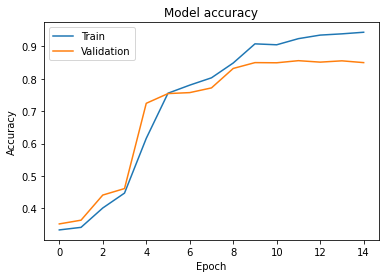

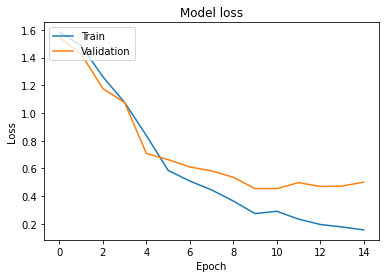

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(X_test_final, y_test_final)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

2000/2000 [==============================] - 41s 21ms/step
Test loss: 0.5717
Test accuracy: 0.8365


In [15]:
y_pred=model.predict_classes(X_test_final)

2000/2000 [==============================] - 42s 21ms/step


In [16]:
# Convert one-hot encoded labels to class labels
y_true = np.argmax(y_test_final, axis=1)

In [17]:
confusion_matrix(y_true, y_pred)

array([[506,  35,  12,  13,  14,   1],
       [ 17, 596,  51,  13,   9,   9],
       [ 11,  37, 107,   3,   1,   0],
       [ 33,   8,   4, 217,  12,   1],
       [ 12,   1,   0,   3, 192,  16],
       [  1,   2,   0,   0,   8,  55]], dtype=int64)

In [18]:
class_names = {
    'sadness':0,
    'joy':1,
    'love':2,
    'anger':3,
    'fear':4,
    'surprise':5
}

In [19]:
# Compute the classification report
report = classification_report(y_true, y_pred,target_names=class_names)

# Print the classification report
print(report)

              precision    recall  f1-score   support

     sadness       0.87      0.87      0.87       581
         joy       0.88      0.86      0.87       695
        love       0.61      0.67      0.64       159
       anger       0.87      0.79      0.83       275
        fear       0.81      0.86      0.83       224
    surprise       0.67      0.83      0.74        66

    accuracy                           0.84      2000
   macro avg       0.79      0.81      0.80      2000
weighted avg       0.84      0.84      0.84      2000



In [20]:
# Save the model
model.save('NLP_Emotion_Detection_Bidirectional_LSTM_final_1.h5')

In [21]:
# Load the saved model
model = load_model('NLP_Emotion_Detection_Bidirectional_LSTM_final_1.h5')

In [22]:
def preprocess_text(text):
    # Preprocess the text
    processed_text = text.lower()
    processed_text = re.sub('[^a-zA-Z]', ' ', processed_text)
    processed_text = processed_text.split()
    ps = PorterStemmer()
    processed_text = [ps.stem(word) for word in processed_text if word not in stopwords.words('english')]
    processed_text = ' '.join(processed_text)

    return processed_text

def preprocess_input(text):
    preprocessed_text = preprocess_text(text)

    # Convert text to one-hot encoding
    voc_size = 5000
    onehot_repr = [one_hot(preprocessed_text, voc_size)]

    # Pad sequence for uniform length
    max_sequence_length = 200
    padded_sequence = pad_sequences(onehot_repr, padding='pre', maxlen=max_sequence_length)

    return padded_sequence

class_names = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

def predict_sentiment(model, text):
    preprocessed_input = preprocess_input(text)
    prediction = model.predict(preprocessed_input)
    predicted_class_index = prediction.argmax(axis=1)[0]
    predicted_class_name = class_names[predicted_class_index]
    predicted_probabilities = prediction[0]
    
    return predicted_class_name, predicted_probabilities

# Load the pre-trained model
loaded_model = load_model('NLP_Emotion_Detection_Bidirectional_LSTM_final_1.h5')

# Set the initial flag value
record_flag = False

# Set up speech recognition
recognizer = sr.Recognizer()

try:
    while True:
        with sr.Microphone() as source:
            print("Listening...")
            audio = recognizer.listen(source)
        
        try:
            # Perform speech recognition on the audio
            result2 = recognizer.recognize_google(audio)
            print("Recognized speech:", result2)
            
            # Perform sentiment analysis
            preprocessed_text = preprocess_text(result2)
            predicted_class, predicted_probabilities = predict_sentiment(loaded_model, preprocessed_text)

            # Print the predicted sentiment
            print(f"Predicted Sentiment: {predicted_class}")
            print("Prediction Probabilities:")
            for class_index, class_name in class_names.items():
                probability = predicted_probabilities[class_index]
                print(f"{class_name}: {probability}")
            print()
        
        except sr.UnknownValueError:
            print("No speech detected.")
            
except KeyboardInterrupt:
    print("Listening interrupted.")


Listening...
result2:
[]
No speech detected.
Listening...
result2:
[]
No speech detected.
Listening...
result2:
[]
No speech detected.
Listening...
result2:
[]
No speech detected.
Listening...
result2:
[]
No speech detected.
Listening...
result2:
[]
No speech detected.
Listening...
result2:
{   'alternative': [   {   'confidence': 0.94643229,
                           'transcript': 'serious it with near you say which '
                                         'made the people more disgusted'},
                       {   'transcript': 'serious it with near you say which '
                                         'made the people more disgusting'},
                       {   'transcript': 'serious at work near you say which '
                                         'made the people more disgusted'},
                       {   'transcript': 'serious near you say which made the '
                                         'people more disgusted'},
                       {   'transcript': '